# **Inversiones**

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

2025-10-16 04:24:32.458479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760588672.715949      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760588672.788394      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# CREAR FUNCIONES
def acciones(name):
  ticker = yf.Ticker(name)
  df_transacciones = ticker.history(period="max")
  df_transacciones=df_transacciones.reset_index()
  return df_transacciones
df=acciones("KO")
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,1962-01-02 00:00:00-05:00,0.045368,0.046604,0.045368,0.045368,806400,0.0,0.0
1,1962-01-03 00:00:00-05:00,0.044695,0.044695,0.043684,0.044358,1574400,0.0,0.0
2,1962-01-04 00:00:00-05:00,0.044470,0.045032,0.044470,0.044695,844800,0.0,0.0
3,1962-01-05 00:00:00-05:00,0.044695,0.045256,0.043572,0.043684,1420800,0.0,0.0
4,1962-01-08 00:00:00-05:00,0.043347,0.043347,0.042392,0.043235,2035200,0.0,0.0


* EMA 20 cruza hacia arriba de EMA 50 = 2
* EMA 20 cruza hacia abajo de EMA 50 = -2

In [3]:
def calcular_emas_y_cruces(df, col_close="Close", ema1=20, ema2=50):
    """
    Calcula las EMAs y detecta señales Buy/Sell (cruces alcistas o bajistas).

    Parámetros:
        df (pd.DataFrame): DataFrame con columna de precios de cierre.
        col_close (str): Nombre de la columna del precio de cierre.
        ema1 (int): Período de la EMA corta (por defecto 20).
        ema2 (int): Período de la EMA larga (por defecto 50).

    Retorna:
        pd.DataFrame: DataFrame con columnas EMA1, EMA2, Signal y Crossover.
    """
    df = df.copy()  # para no modificar el original

    # Calcular EMAs
    df[f"EMA{ema1}"] = df[col_close].ewm(span=ema1, adjust=False).mean()
    df[f"EMA{ema2}"] = df[col_close].ewm(span=ema2, adjust=False).mean()

    # Detectar señales alcistas/bajistas
    df["Signal"] = 0
    df.loc[df[f"EMA{ema1}"] > df[f"EMA{ema2}"], "Signal"] = 1
    df.loc[df[f"EMA{ema1}"] < df[f"EMA{ema2}"], "Signal"] = -1

    # Detectar puntos de cruce
    df["Crossover"] = df["Signal"].diff()

    return df


In [4]:
df = calcular_emas_y_cruces(df)
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,EMA50,Signal,Crossover
0,1962-01-02 00:00:00-05:00,0.045368,0.046604,0.045368,0.045368,806400,0.0,0.0,0.045368,0.045368,0,NaN
1,1962-01-03 00:00:00-05:00,0.044695,0.044695,0.043684,0.044358,1574400,0.0,0.0,0.045272,0.045329,-1,-1.0
2,1962-01-04 00:00:00-05:00,0.044470,0.045032,0.044470,0.044695,844800,0.0,0.0,0.045217,0.045304,-1,0.0
3,1962-01-05 00:00:00-05:00,0.044695,0.045256,0.043572,0.043684,1420800,0.0,0.0,0.045071,0.045240,-1,0.0
4,1962-01-08 00:00:00-05:00,0.043347,0.043347,0.042392,0.043235,2035200,0.0,0.0,0.044896,0.045162,-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16050,2025-10-09 00:00:00-04:00,66.290001,66.800003,66.120003,66.370003,12705200,0.0,0.0,66.590983,67.429783,-1,0.0
16051,2025-10-10 00:00:00-04:00,66.519997,67.400002,66.379997,67.040001,17991700,0.0,0.0,66.633746,67.414498,-1,0.0
16052,2025-10-13 00:00:00-04:00,66.230003,66.800003,66.000000,66.800003,13690000,0.0,0.0,66.649580,67.390400,-1,0.0
16053,2025-10-14 00:00:00-04:00,66.870003,67.570000,66.750000,67.510002,14245600,0.0,0.0,66.731525,67.395090,-1,0.0


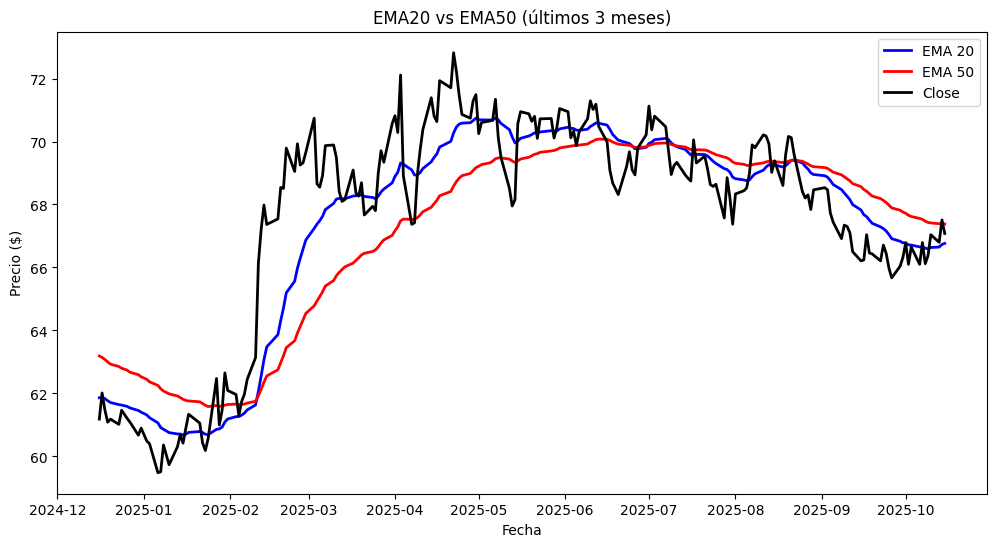

In [5]:
# 🔹 Filtrar últimos 10 meses desde la fecha más reciente
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# 🔹 Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)
sns.lineplot(data=df_3m,x='Date',y='Close',label='Close',color='Black',linewidth=2)

plt.title("EMA20 vs EMA50 (últimos 3 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.show()

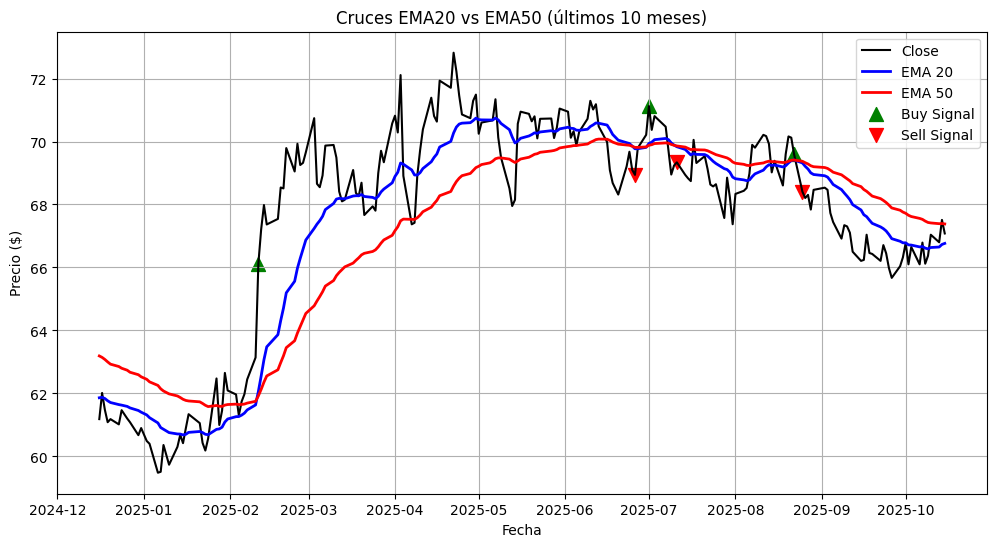

In [6]:
# 🔹 Filtrar últimos 10 meses (ajustable)
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# Puntos Buy/Sell dentro del rango filtrado
buy_signals = df_3m[df_3m["Crossover"] == 2]   # Cruce EMA20 sobre EMA50
sell_signals = df_3m[df_3m["Crossover"] == -2] # Cruce EMA20 bajo EMA50

# 🔹 Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=df_3m, x="Date", y="Close", label="Close", color="black", linewidth=1.5)
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)

# Marcar señales de compra/venta
plt.scatter(buy_signals["Date"], buy_signals["Close"], marker="^", color="green", s=100, label="Buy Signal")
plt.scatter(sell_signals["Date"], sell_signals["Close"], marker="v", color="red", s=100, label="Sell Signal")

plt.title("Cruces EMA20 vs EMA50 (últimos 10 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.grid(True)
plt.show()

# **NVDIA**

In [7]:
df=acciones("NVDA")
df = calcular_emas_y_cruces(df)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,EMA50,Signal,Crossover
0,1999-01-22 00:00:00-05:00,0.040114,0.044770,0.035577,0.037607,2714688000,0.0,0.0,0.037607,0.037607,0,NaN
1,1999-01-25 00:00:00-05:00,0.040591,0.042024,0.037607,0.041547,510480000,0.0,0.0,0.037982,0.037761,1,1.0
2,1999-01-26 00:00:00-05:00,0.042024,0.042860,0.037726,0.038323,343200000,0.0,0.0,0.038015,0.037784,1,0.0
3,1999-01-27 00:00:00-05:00,0.038442,0.039398,0.036293,0.038204,244368000,0.0,0.0,0.038033,0.037800,1,0.0
4,1999-01-28 00:00:00-05:00,0.038204,0.038442,0.037845,0.038084,227520000,0.0,0.0,0.038038,0.037811,1,0.0


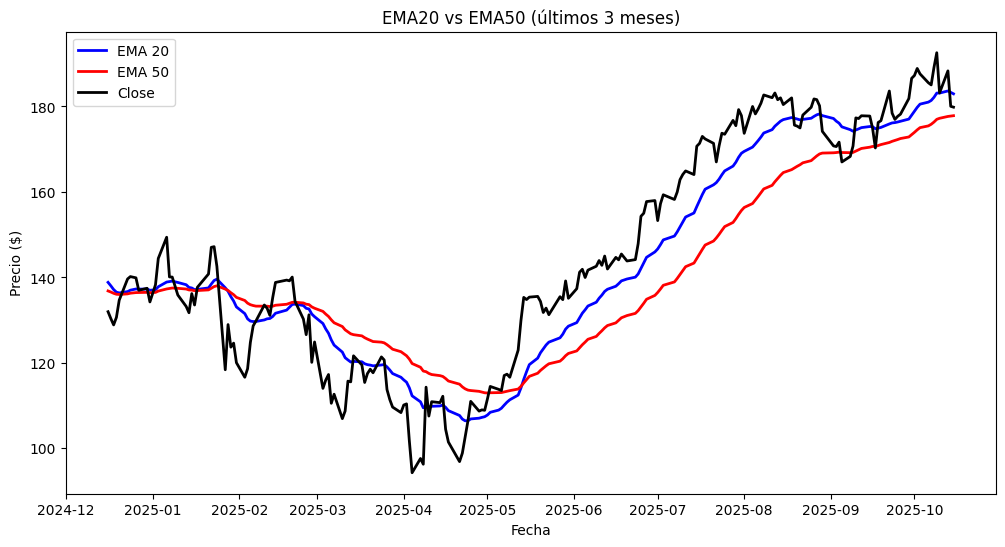

In [8]:
# 🔹 Filtrar últimos 10 meses desde la fecha más reciente
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# 🔹 Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)
sns.lineplot(data=df_3m,x='Date',y='Close',label='Close',color='Black',linewidth=2)

plt.title("EMA20 vs EMA50 (últimos 3 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.show()

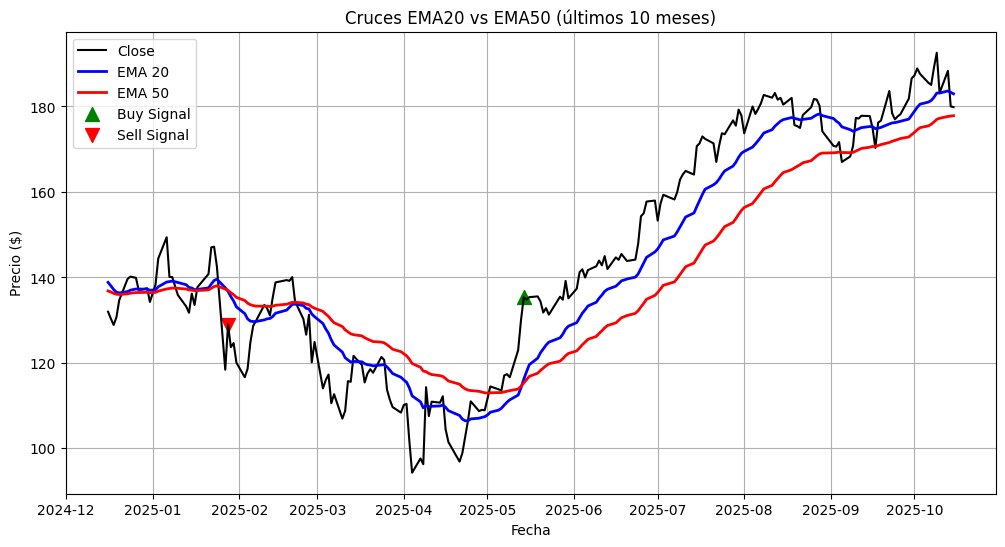

In [9]:
# 🔹 Filtrar últimos 10 meses (ajustable)
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# Puntos Buy/Sell dentro del rango filtrado
buy_signals = df_3m[df_3m["Crossover"] == 2]   # Cruce EMA20 sobre EMA50
sell_signals = df_3m[df_3m["Crossover"] == -2] # Cruce EMA20 bajo EMA50

# 🔹 Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=df_3m, x="Date", y="Close", label="Close", color="black", linewidth=1.5)
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)

# Marcar señales de compra/venta
plt.scatter(buy_signals["Date"], buy_signals["Close"], marker="^", color="green", s=100, label="Buy Signal")
plt.scatter(sell_signals["Date"], sell_signals["Close"], marker="v", color="red", s=100, label="Sell Signal")

plt.title("Cruces EMA20 vs EMA50 (últimos 10 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.grid(True)
plt.show()

## **Verizone**

In [10]:
df=acciones("VZ")
df = calcular_emas_y_cruces(df)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,EMA50,Signal,Crossover
0,1983-11-21 00:00:00-05:00,1.058585,1.060459,0.983641,1.052965,5020667,0.0,0.0,1.052965,1.052965,0,NaN
1,1983-11-22 00:00:00-05:00,1.052964,1.067953,1.047343,1.049217,2666896,0.0,0.0,1.052608,1.052818,-1,-1.0
2,1983-11-23 00:00:00-05:00,1.049217,1.052964,1.037975,1.043596,1151978,0.0,0.0,1.051749,1.052456,-1,0.0
3,1983-11-25 00:00:00-05:00,1.043596,1.045469,1.032354,1.032354,1772000,0.0,0.0,1.049902,1.051668,-1,0.0
4,1983-11-28 00:00:00-05:00,1.026733,1.026733,1.000502,1.004249,2368004,0.0,0.0,1.045554,1.049808,-1,0.0


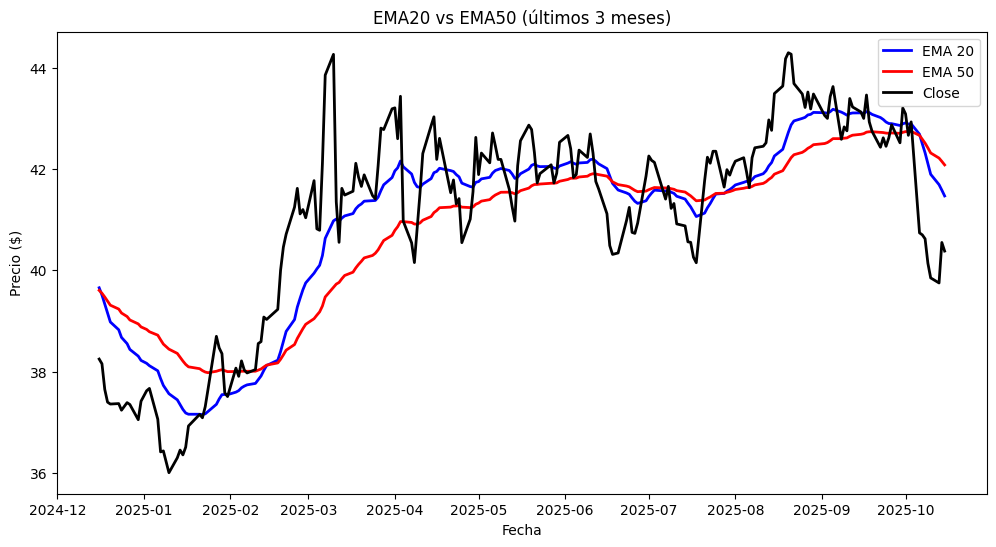

In [11]:
# 🔹 Filtrar últimos 10 meses desde la fecha más reciente
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# 🔹 Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)
sns.lineplot(data=df_3m,x='Date',y='Close',label='Close',color='Black',linewidth=2)

plt.title("EMA20 vs EMA50 (últimos 3 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.show()

## **QUBT**

In [12]:
df=acciones("QUBT")
df = calcular_emas_y_cruces(df)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,EMA50,Signal,Crossover
0,2007-02-01 00:00:00-05:00,4000.0,4000.0,4000.0,4000.0,0,0.0,0.0,4000.0,4000.0,0,NaN
1,2007-02-02 00:00:00-05:00,4000.0,4000.0,4000.0,4000.0,0,0.0,0.0,4000.0,4000.0,0,0.0
2,2007-02-05 00:00:00-05:00,4000.0,4000.0,4000.0,4000.0,0,0.0,0.0,4000.0,4000.0,0,0.0
3,2007-02-06 00:00:00-05:00,4000.0,4000.0,4000.0,4000.0,0,0.0,0.0,4000.0,4000.0,0,0.0
4,2007-02-07 00:00:00-05:00,4000.0,4000.0,4000.0,4000.0,0,0.0,0.0,4000.0,4000.0,0,0.0


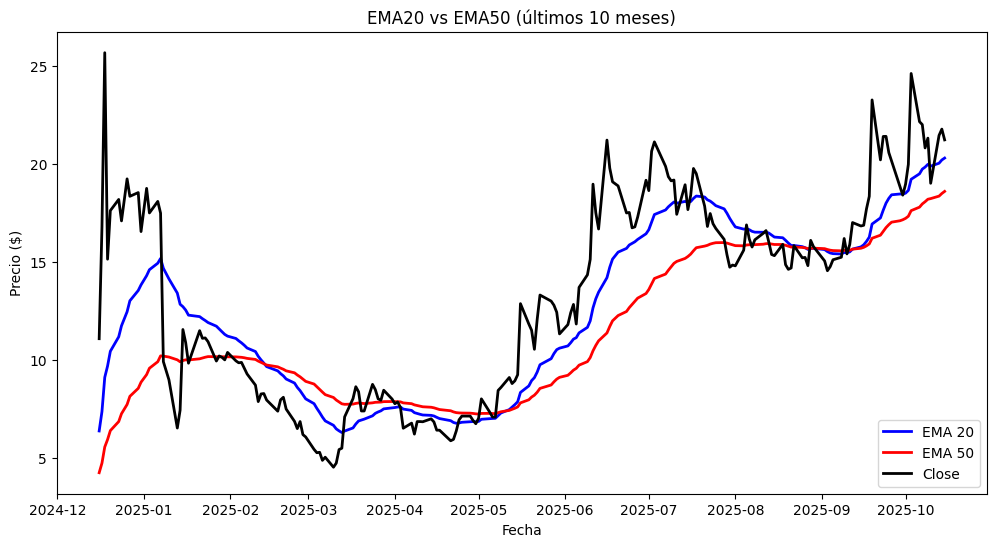

In [13]:
# 🔹 Filtrar últimos 10 meses desde la fecha más reciente
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# 🔹 Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)
sns.lineplot(data=df_3m,x='Date',y='Close',label='Close',color='Black',linewidth=2)

plt.title("EMA20 vs EMA50 (últimos 10 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.show()

In [14]:
# Calcular RSI (período 14)
delta = df["Close"].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

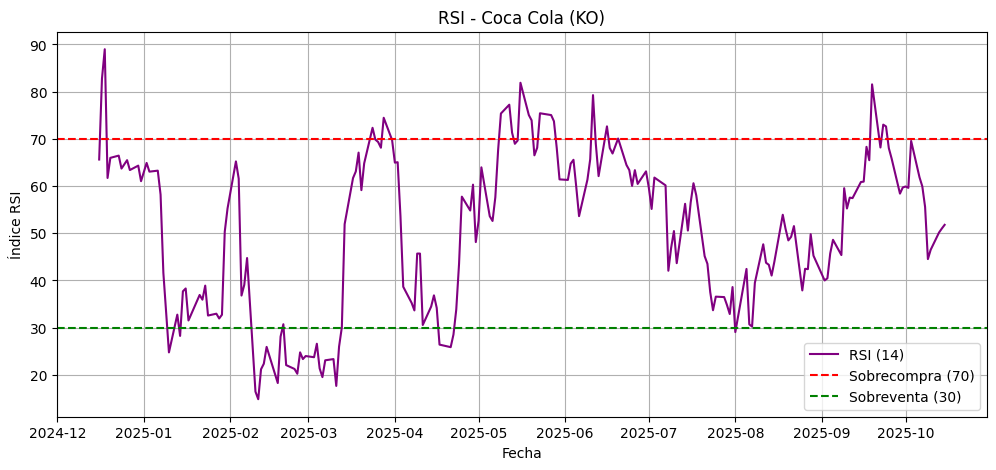

In [15]:
# 🔹 Filtrar últimos 10 meses desde la fecha más reciente
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# Graficar RSI
plt.figure(figsize=(12,5))
plt.plot(df_3m['Date'], df_3m["RSI"], label="RSI (14)", color="purple")
plt.axhline(70, color="red", linestyle="--", label="Sobrecompra (70)")
plt.axhline(30, color="green", linestyle="--", label="Sobreventa (30)")
plt.title("RSI - Coca Cola (KO)")
plt.xlabel("Fecha")
plt.ylabel("Índice RSI")
plt.legend()
plt.grid(True)
plt.show()

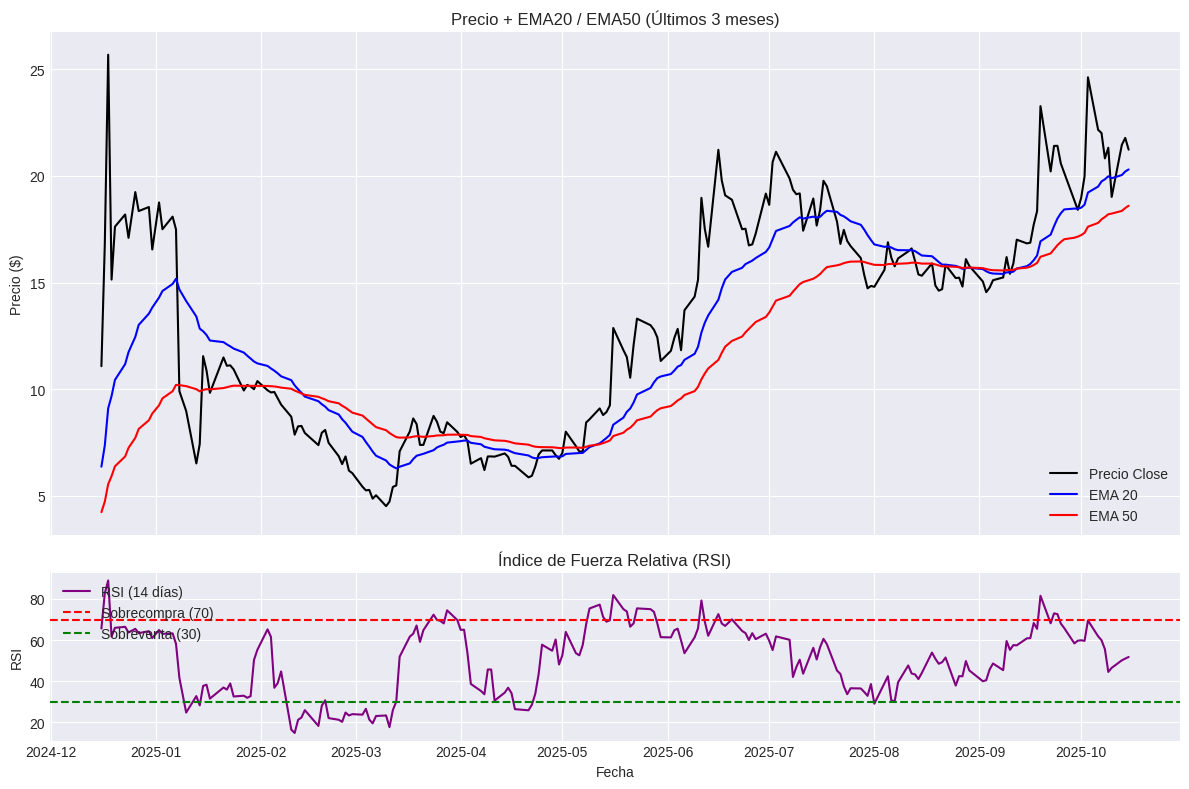

In [16]:
# ==========================
# 3️⃣ Graficar Precio + EMA y RSI
# ==========================
plt.style.use("seaborn-v0_8-darkgrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), sharex=True, gridspec_kw={'height_ratios':[3,1]})

# --- Gráfico 1: Precio + EMA20 + EMA50 ---
sns.lineplot(data=df_3m, x="Date", y="Close", label="Precio Close", color="black", ax=ax1)
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", ax=ax1)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", ax=ax1)
ax1.set_title("Precio + EMA20 / EMA50 (Últimos 3 meses)")
ax1.set_ylabel("Precio ($)")
ax1.legend()

# --- Gráfico 2: RSI ---
sns.lineplot(data=df_3m, x="Date", y="RSI", label="RSI (14 días)", color="purple", ax=ax2)
ax2.axhline(70, color="red", linestyle="--", label="Sobrecompra (70)")
ax2.axhline(30, color="green", linestyle="--", label="Sobreventa (30)")
ax2.set_ylabel("RSI")
ax2.set_xlabel("Fecha")
ax2.set_title("Índice de Fuerza Relativa (RSI)")
ax2.legend(loc="upper left")

plt.tight_layout()
plt.show()

## **XRP**

In [17]:
df=acciones("XRP-USD")
df = calcular_emas_y_cruces(df)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,EMA20,EMA50,Signal,Crossover
0,2017-11-09 00:00:00+00:00,0.217911,0.221791,0.214866,0.217488,147916992,0.0,0.0,0.217488,0.217488,0,NaN
1,2017-11-10 00:00:00+00:00,0.218256,0.219068,0.205260,0.206483,141032992,0.0,0.0,0.216440,0.217056,-1,-1.0
2,2017-11-11 00:00:00+00:00,0.205948,0.214456,0.205459,0.210430,134503008,0.0,0.0,0.215868,0.216797,-1,0.0
3,2017-11-12 00:00:00+00:00,0.210214,0.210214,0.195389,0.197339,251175008,0.0,0.0,0.214103,0.216034,-1,0.0
4,2017-11-13 00:00:00+00:00,0.197472,0.204081,0.197456,0.203442,132567000,0.0,0.0,0.213088,0.215540,-1,0.0


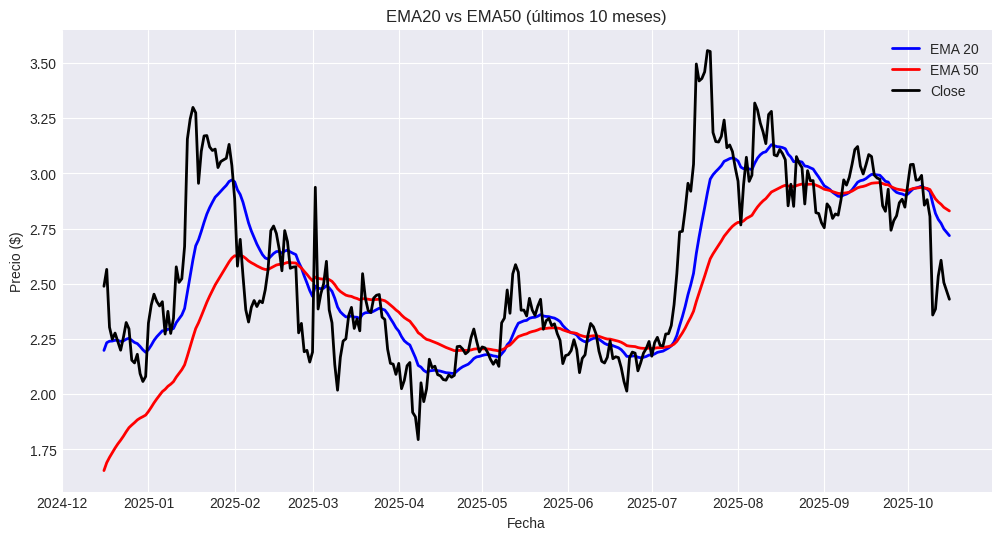

In [18]:
# 🔹 Filtrar últimos 10 meses desde la fecha más reciente
fecha_limite = df["Date"].max() - pd.DateOffset(months=10)
df_3m = df[df["Date"] >= fecha_limite]

# 🔹 Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=df_3m, x="Date", y="EMA20", label="EMA 20", color="blue", linewidth=2)
sns.lineplot(data=df_3m, x="Date", y="EMA50", label="EMA 50", color="red", linewidth=2)
sns.lineplot(data=df_3m,x='Date',y='Close',label='Close',color='Black',linewidth=2)

plt.title("EMA20 vs EMA50 (últimos 10 meses)")
plt.xlabel("Fecha")
plt.ylabel("Precio ($)")
plt.legend()
plt.show()